In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import TensorBoard
import time

In [2]:
#Added to avoid Kernel crash.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:

# Load the pre-trained MobileNetV2 model, excluding the top classification layer.
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

In [4]:
# Freeze the base model
base_model.trainable = False

In [5]:
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense

In [6]:
# Create new model on top
inputs = Input(shape=(96, 96, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs, outputs)

In [7]:
# Downloading and Processing the Data.

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [8]:
# Load CIFAR-10 data
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [9]:
train_images[0].shape

(32, 32, 3)

In [10]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [11]:
# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

In [12]:
# Resize images from 32x32 to 96x96 to fit MobileNetV2 input size requirements
train_images_resized = tf.image.resize(train_images, (96, 96))
test_images_resized = tf.image.resize(test_images, (96, 96))

In [13]:
# Compiling and Training the Model
from tensorflow.keras.optimizers import Adam

In [14]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Train the model
history = model.fit(
 train_images_resized, train_labels, 
 epochs=5, 
 batch_size = 128,
 validation_split=0.3,
)

Epoch 1/5
274/274 [==============================] - 74s 256ms/step - loss: 0.8836 - accuracy: 0.6961 - val_loss: 0.6770 - val_accuracy: 0.7647
Epoch 2/5
274/274 [==============================] - 70s 255ms/step - loss: 0.6273 - accuracy: 0.7841 - val_loss: 0.6219 - val_accuracy: 0.7829
Epoch 3/5
274/274 [==============================] - 71s 258ms/step - loss: 0.5717 - accuracy: 0.8014 - val_loss: 0.6061 - val_accuracy: 0.7877
Epoch 4/5
274/274 [==============================] - 77s 282ms/step - loss: 0.5392 - accuracy: 0.8134 - val_loss: 0.5995 - val_accuracy: 0.7918
Epoch 5/5
274/274 [==============================] - 78s 285ms/step - loss: 0.5154 - accuracy: 0.8198 - val_loss: 0.5780 - val_accuracy: 0.7994


In [16]:
# Evaluate the model
test_acc,test_loss = model.evaluate(test_images_resized, test_labels)

313/313 [==============================] - 19s 59ms/step - loss: 0.5722 - accuracy: 0.8006


In [17]:
print(test_acc,test_loss)

0.5722423791885376 0.800599992275238


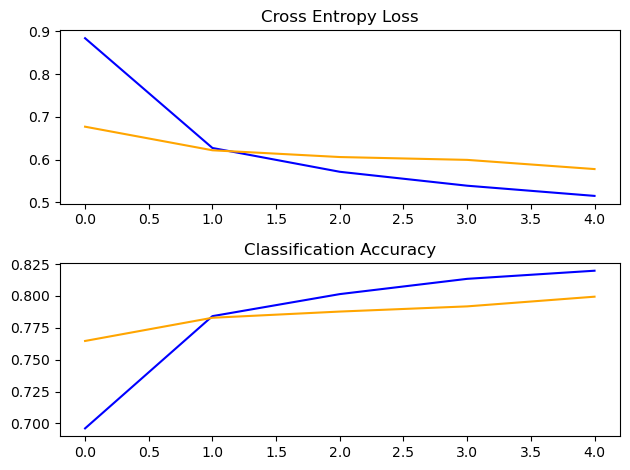

In [18]:
#Show the plots during the training for the loss and accuracy of the training and validation data.

plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color = 'blue', label='train')
plt.plot(history.history['val_loss'],color = 'orange', label='test')

plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'],color = 'blue', label='train')
plt.plot(history.history['val_accuracy'],color = 'orange', label='test')

plt.tight_layout()
plt.show()

In [19]:
#What accuracy did the model achieve on the training, validation data, and test data?
predictions = model.predict(test_images_resized)

313/313 [==============================] - 20s 59ms/step


In [20]:
predictions.shape,test_labels.shape

((10000, 10), (10000, 10))

In [21]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(np.argmax(predictions,axis=1),np.argmax(test_labels,axis=1)))

[[805   9  38  12  10   1   4  13  38   7]
 [ 12 896   2   7   2   1   2   3  15  62]
 [ 38   1 721  46  58  29  31  13   8   2]
 [ 10   6  58 673  48 143  40  26   3   4]
 [  9   0  62  21 704  28  18  30   2   3]
 [  0   1  36  96  18 674  14  33   1   1]
 [  1   4  59  70  63  36 875   9   4   1]
 [ 12   1  15  44  85  73   9 862   3   6]
 [ 78  33   9  20  11  10   1   3 906  24]
 [ 35  49   0  11   1   5   6   8  20 890]]


In [22]:
print(classification_report(np.argmax(predictions,axis=1),np.argmax(test_labels,axis=1)))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       937
           1       0.90      0.89      0.90      1002
           2       0.72      0.76      0.74       947
           3       0.67      0.67      0.67      1011
           4       0.70      0.80      0.75       877
           5       0.67      0.77      0.72       874
           6       0.88      0.78      0.82      1122
           7       0.86      0.78      0.82      1110
           8       0.91      0.83      0.86      1095
           9       0.89      0.87      0.88      1025

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



In [23]:
model.save('CIFAR10-Dataset.h5')

In [24]:
#Task 2: Optimizing the model
#Grid Search Optimization

batch_sizes = [32,64,128]
layer_sizes = [96,64,32]

for bt_size in batch_sizes:
    for layer_size in layer_sizes:
        file_name = "{}-batchsize-{}-layersize-{}".format(bt_size,layer_size,int(time.time()))
        log_dir = "GridSearch_Logs/" + file_name
        print(log_dir)
        tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1)
        #Define the model
        inputs = Input(shape=(96, 96, 3))
        x = base_model(inputs)
        x = GlobalAveragePooling2D()(x)
        #Added this extra layer to check the variations in the Grid Search
        layer = Dense(layer_size,activation='ReLU')(x)
        outputs = Dense(10, activation='softmax')(layer)
        model = Model(inputs, outputs)
        #Compiling the model with the necessary hyper parameters.
        model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
        #Writing the models fit data.
        model.fit(train_images_resized, train_labels, epochs=5, batch_size = bt_size,validation_split=0.3,callbacks=[tensorboard_callback],verbose=0)
        #Evaluate the Model
        model.evaluate(test_images_resized, test_labels)

GridSearch_Logs/32-batchsize-96-layersize-1702078945
313/313 [==============================] - 18s 58ms/step - loss: 0.6010 - accuracy: 0.8019
GridSearch_Logs/32-batchsize-64-layersize-1702079408
313/313 [==============================] - 18s 57ms/step - loss: 0.5986 - accuracy: 0.7962
GridSearch_Logs/32-batchsize-32-layersize-1702079858
313/313 [==============================] - 18s 57ms/step - loss: 0.6031 - accuracy: 0.7965
GridSearch_Logs/64-batchsize-96-layersize-1702080322
313/313 [==============================] - 18s 58ms/step - loss: 0.5903 - accuracy: 0.8023
GridSearch_Logs/64-batchsize-64-layersize-1702080736
313/313 [==============================] - 17s 55ms/step - loss: 0.5805 - accuracy: 0.7996
GridSearch_Logs/64-batchsize-32-layersize-1702081146
313/313 [==============================] - 17s 56ms/step - loss: 0.5826 - accuracy: 0.7995
GridSearch_Logs/128-batchsize-96-layersize-1702081576
313/313 [==============================] - 19s 61ms/step - loss: 0.5956 - accuracy

In [48]:
# Instructions to view in TensorBoard
print("To view the TensorBoard logs, run: tensorboard --logdir logs4/")

To view the TensorBoard logs, run: tensorboard --logdir logs4/


In [55]:
#From the above trained data we can say that the data having the batchsize 128 and layer size 64 provided best results.
#Random Search Optimization.

epochs = [5,10,15]
activations=['relu','tanh']
optimizers = ['Adam','RMSprop']

import random

iterations = random.choice(np.arange(5,12))

for _ in range(iterations):
    
    #Randomly selecting the epochs
    epoch = random.choice(epochs)
    
    #Randomly selecting the Activations.
    activation_fun = random.choice(activations)
    
    #Randomly selecting the Optimizers.
    rand_optimizer = random.choice(optimizers)
    
    file_name = "{}-epochs-{}-activation-{}-optimizer-{}".format(epoch,activation_fun,rand_optimizer,int(time.time()))
    log_dir = "RandomSearch_Logs/" + file_name
    print(log_dir)
    tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1)
    #Define the model
    inputs = Input(shape=(96, 96, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    #Added this extra layer to check the variations in the Grid Search
    layer = Dense(64,activation=activation_fun)(x)
    outputs = Dense(10, activation='softmax')(layer)
    model = Model(inputs, outputs)
    
    #Compiling the model with the necessary hyper parameters.
    model.compile(optimizer=rand_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    #Writing the models fit data.
    model.fit(train_images_resized, train_labels, epochs=epoch, batch_size = 128,validation_split=0.3,callbacks=[tensorboard_callback],verbose=0)
    
    #Evaluate the Model
    model.evaluate(test_images_resized, test_labels)

RandomSearch_Logs/5-epochs-relu-activation-RMSprop-optimizer-1702084670
313/313 [==============================] - 18s 58ms/step - loss: 0.6252 - accuracy: 0.7879
RandomSearch_Logs/10-epochs-tanh-activation-RMSprop-optimizer-1702085064
313/313 [==============================] - 19s 61ms/step - loss: 0.6204 - accuracy: 0.7979
RandomSearch_Logs/15-epochs-relu-activation-Adam-optimizer-1702085829
313/313 [==============================] - 17s 54ms/step - loss: 0.6603 - accuracy: 0.8031
RandomSearch_Logs/10-epochs-tanh-activation-Adam-optimizer-1702087053
313/313 [==============================] - 16s 51ms/step - loss: 0.6044 - accuracy: 0.8049
RandomSearch_Logs/10-epochs-tanh-activation-RMSprop-optimizer-1702087845
313/313 [==============================] - 19s 61ms/step - loss: 0.6276 - accuracy: 0.7976
RandomSearch_Logs/10-epochs-relu-activation-RMSprop-optimizer-1702088624
313/313 [==============================] - 18s 58ms/step - loss: 0.6390 - accuracy: 0.7935
